# Analysis of studio recordings and live performances of songs
#### This notebook contains code to analyze a dataset with musical features of songs, as provided by the spotify API. It also contains labels as to whether a song is recorded at a studio or it is a live performance.

### Let's import the required libraries

In [250]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

### Load the dataset

In [273]:
# Load the combined CSV file into a Pandas dataframe
df = pd.read_csv('songs.csv')

### Exploring the data

In [236]:
df.head(10)

,id,energy,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,label
0,7xHATAMD7ezTZGYsNAMr5R,0.781,0.379,0,-6.147,0,0.0417,0.315000,0.000162,0.401,0.327,77.567,147840,4,live
1,69daVl60U0WWueFAUSQFih,0.875,0.612,9,-6.981,1,0.0546,0.341000,0.006200,0.951,0.413,150.093,185387,4,live
2,4gzSuZQoKUG3ztXErLlc0K,0.925,0.574,6,-5.955,0,0.0386,0.001080,0.004080,0.973,0.780,138.845,223707,4,live
3,0qYNU0d6q2797FZwc4HXoJ,0.907,0.463,1,-6.732,0,0.0889,0.065000,0.000059,0.768,0.593,165.427,267373,4,live
4,7ajzjngqdDOXNaxP2GHz4C,0.911,0.599,6,-5.715,0,0.0367,0.005530,0.004390,0.561,0.382,121.911,252973,4,live
5,05ngn5qJ42mN6HEtrxuhI7,0.965,0.567,9,-5.460,0,0.0515,0.040700,0.000005,0.974,0.489,129.006,293347,4,live
6,4unD2O56RtWAMLuZLWTWbr,0.993,0.163,3,-3.600,1,0.1420,0.000158,0.086800,0.722,0.160,175.122,178107,4,live
7,19dqbkqEgpgUZsh7FXftIs,0.951,0.644,7,-9.867,1,0.0406,0.108000,0.017200,0.657,0.971,128.091,241360,4,live
8,1DJfcWfj5dSIzksFpnRr3S,0.967,0.562,9,-4.919,0,0.2710,0.049600,0.000074,0.953,0.268,99.130,323733,4,live
9,5s457o0GLooprDJNitW5WF,0.967,0.352,1,-4.811,1,0.1540,0.000089,0.000000,0.547,0.127,144.717,233440,4,live


### Shuffle the data

In [237]:
df = df.sample(frac=1)
df.head(10)

,id,energy,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,label
2417,6bqhb4rqiUofKHGAB8PHdN,0.750,0.541,10,-6.561,1,0.0971,0.0160,0.000000,0.2940,0.6630,160.006,228773,4,studio
3940,5DiXcVovI0FcY2s0icWWUu,0.817,0.578,0,-6.542,1,0.0363,0.1830,0.000003,0.2850,0.7260,141.621,272293,4,studio
4000,7nemcVsXVFZF01iqpIIo2Y,0.863,0.456,3,-3.551,1,0.0894,0.1330,0.053800,0.0553,0.5320,135.962,301227,4,studio
1311,1u5wntFKJGbUjHxqLeEBu8,0.923,0.415,9,-5.427,1,0.0558,0.2360,0.000160,0.6900,0.4350,156.572,406240,4,live
591,2gi7TNOUINqxYzxFM46EOX,0.854,0.374,6,-6.939,0,0.0963,0.2420,0.000002,0.8080,0.4440,135.597,497173,4,live
4568,1xqjLdtB558KjSo7zvOXua,0.494,0.678,6,-9.539,0,0.2450,0.1850,0.009400,0.2010,0.0763,130.026,387692,4,studio
1352,6mwFT5zjRybxTL2cON4M1K,0.940,0.348,4,-4.016,1,0.1550,0.2970,0.001560,0.6420,0.5330,157.397,225053,4,live
4484,1cTZMwcBJT0Ka3UJPXOeeN,0.913,0.567,8,-6.471,1,0.0736,0.0934,0.000124,0.1140,0.7920,93.350,210926,4,studio
2247,2rBo6CIB4gp0wASTHCtWpf,0.902,0.285,4,-7.919,1,0.0732,0.0225,0.000000,0.7140,0.6860,144.676,174080,4,live
831,58thlEaWWLRVVLPs35g7aJ,0.975,0.335,7,-7.066,1,0.0628,0.0224,0.022800,0.9410,0.8060,92.292,141000,4,live


In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4643 entries, 2417 to 3976
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                4643 non-null   object 
 1   energy            4643 non-null   float64
 2   danceability      4643 non-null   float64
 3   key               4643 non-null   int64  
 4   loudness          4643 non-null   float64
 5   mode              4643 non-null   int64  
 6   speechiness       4643 non-null   float64
 7   acousticness      4643 non-null   float64
 8   instrumentalness  4643 non-null   float64
 9   liveness          4643 non-null   float64
 10  valence           4643 non-null   float64
 11  tempo             4643 non-null   float64
 12  duration_ms       4643 non-null   int64  
 13  time_signature    4643 non-null   int64  
 14  label             4643 non-null   object 
dtypes: float64(9), int64(4), object(2)
memory usage: 580.4+ KB


### Drop duplicates

In [274]:
df = df.drop_duplicates()

### What is the distribution of the labels?

In [241]:
# Count the number of samples in each class
class_counts = df['label'].value_counts()

# Print the number of samples in each class
print(class_counts)


label
live      2348
studio    2295
Name: count, dtype: int64


### From the spotify documentation: "A value above 0.8 provides strong likelihood that the track is live."
##### But as we can see below, 22.18% of the songs labeled as 'live', have a value below 0.8 in liveness

In [289]:
total_rows = len(df)
count = len(df[(df['label'] == 'live') & (df['liveness'] < 0.8)])
percentage = (count / total_rows) * 100
print(f"The percentage of rows with label 'live' and liveness < 0.8: {percentage:.2f}%")

The percentage of rows with label 'live' and liveness < 0.8: 22.18%


### Preprocessing

In [290]:
# Drop the columns 'id', 'key', 'mode' and 'signature' as well, because they are irrelevant to this analysis
df = df.drop(['id','mode', 'key', 'time_signature'] , axis=1)
# Select the numerical columns that need to be scaled
num_cols = ['energy', 'danceability', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Perform standardization on the selected columns
# scaler = StandardScaler()
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Map the labels to integer values
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Create a dictionary mapping integer values to their corresponding labels
label_map = {i: label_encoder.inverse_transform([i])[0] for i in range(len(label_encoder.classes_))}

df.head(10)

,energy,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,label
0,0.780364,0.347874,0.761807,0.021019,0.317539,0.000171,0.388151,0.312993,0.199486,0.067238,0
1,0.875506,0.605846,0.728398,0.035597,0.343749,0.006533,0.949949,0.403472,0.635083,0.088985,0
2,0.926113,0.563773,0.769499,0.017516,0.001087,0.004299,0.972421,0.789584,0.567526,0.111179,0
3,0.907895,0.440877,0.738373,0.074359,0.065523,0.000062,0.763023,0.592846,0.727180,0.136470,0
4,0.911943,0.591453,0.779113,0.015369,0.005573,0.004626,0.551583,0.370857,0.465819,0.128130,0
5,0.966599,0.556023,0.789328,0.032094,0.041027,0.000005,0.973442,0.483430,0.508433,0.151514,0
6,0.994939,0.108725,0.863838,0.134365,0.000157,0.091465,0.716037,0.137296,0.785409,0.084768,0
7,0.952429,0.641275,0.612787,0.019776,0.108869,0.018124,0.649642,0.990531,0.502937,0.121403,0
8,0.968623,0.550487,0.811000,0.280145,0.049998,0.000078,0.951992,0.250921,0.328995,0.169113,0
9,0.968623,0.317981,0.815327,0.147926,0.000088,0.000000,0.537283,0.102578,0.602794,0.116816,0


In [243]:
label_map

{0: 'live', 1: 'studio'}

### Visualizing the data

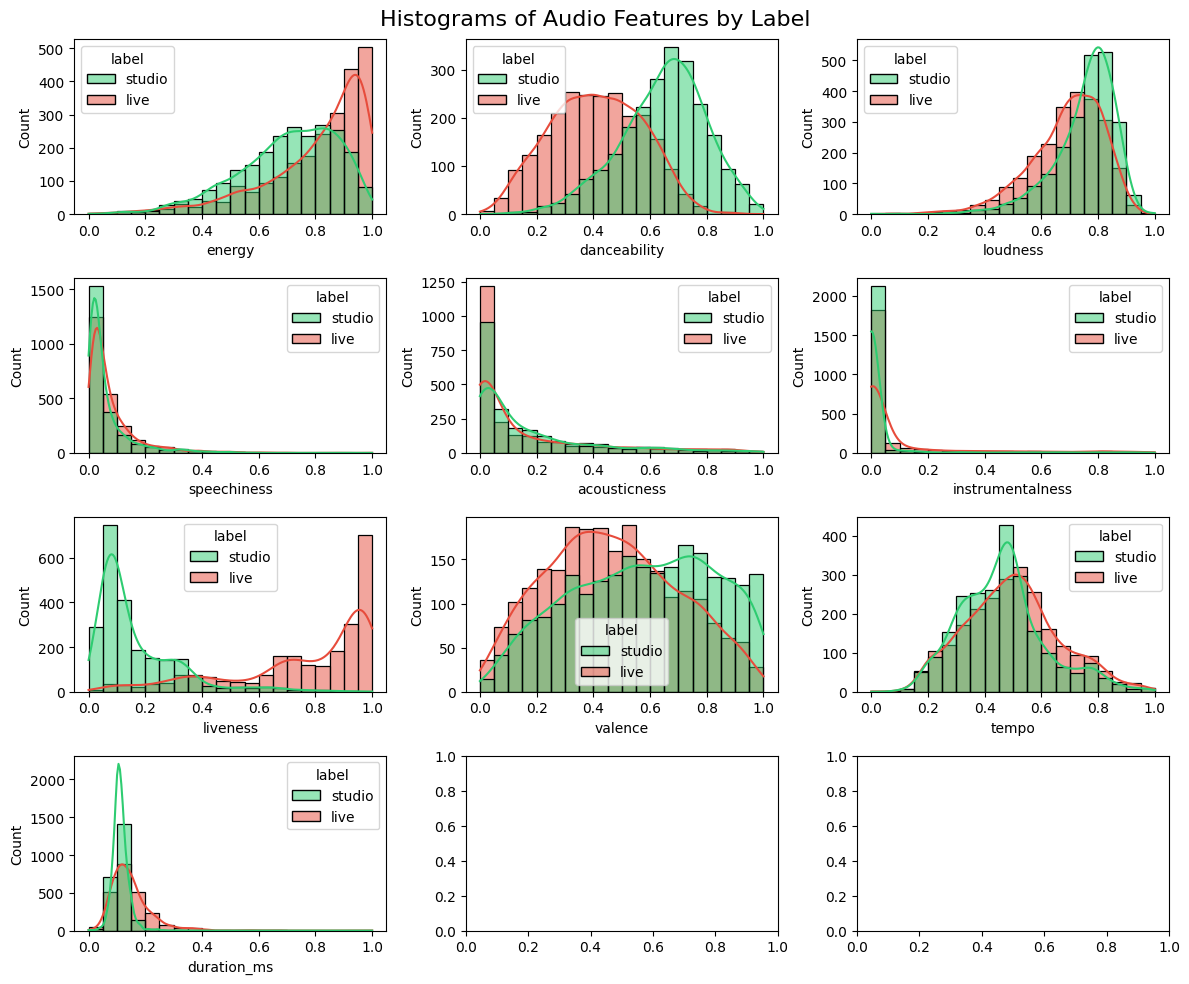

In [244]:
# Define the color palette
colors = ['#2ecc71', '#e74c3c']

nrows = 4
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))
for i, feature in enumerate(df.columns[:-1]):
    row, col = i // 3, i % 3
    if row < nrows and col < ncols:
        ax = axes[row, col]
        sns.histplot(data=df, x=feature, hue=df['label'].map(label_map), ax=ax, kde=True, bins=20, palette=colors)
        ax.set_xlabel(feature)
        


# Add a title to the figure
fig.suptitle("Histograms of Audio Features by Label", fontsize=16)

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the figure
plt.show()

### tSNE vs PCA (2d)

In [264]:
tsne = TSNE(n_components=2, random_state=7)
pca = PCA(n_components=2, random_state=7)

data_tsne = tsne.fit_transform(df)
data_pca = pca.fit_transform(df)

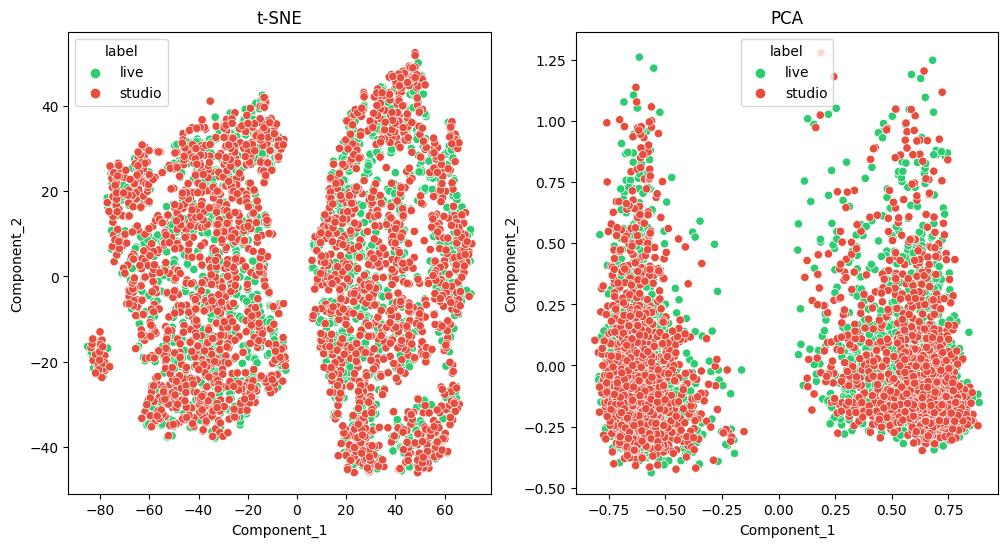

In [265]:
data_tsne_df = pd.DataFrame(data_tsne, columns=['Component_1', 'Component_2'])
data_pca_df = pd.DataFrame(data_pca, columns=['Component_1', 'Component_2'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.scatterplot(data=data_tsne_df, x="Component_1", y="Component_2", hue=df['label'].map(label_map), ax=axes[0], palette=colors)

axes[0].set_title("t-SNE")

sns.scatterplot(data=data_pca_df, x="Component_1", y="Component_2", hue=df['label'].map(label_map), ax=axes[1], palette=colors)

axes[1].set_title("PCA")

plt.show()

### tSNE vs PCA (3d)

In [261]:
tsne = TSNE(n_components=3, random_state=7)
pca = PCA(n_components=3, random_state=7)

data_tsne = tsne.fit_transform(df)
data_pca = pca.fit_transform(df)

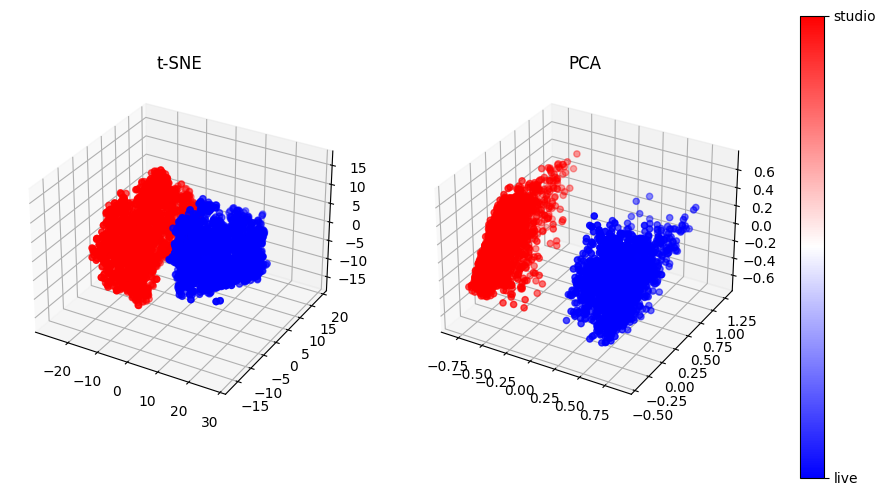

In [263]:
data_tsne_df = pd.DataFrame(data_tsne, columns=['Component_1', 'Component_2', 'Component_3'])
data_pca_df = pd.DataFrame(data_pca, columns=['Component_1', 'Component_2', 'Component_3'])

fig = plt.figure(figsize=(12, 6))
ax_tsne = fig.add_subplot(121, projection='3d')
ax_pca = fig.add_subplot(122, projection='3d')

scatter_tsne = ax_tsne.scatter(data_tsne_df['Component_1'], data_tsne_df['Component_2'], data_tsne_df['Component_3'], c=df['label'], cmap='bwr')
scatter_pca = ax_pca.scatter(data_pca_df['Component_1'], data_pca_df['Component_2'], data_pca_df['Component_3'], c=df['label'], cmap='bwr')

ax_tsne.set_title("t-SNE")
ax_pca.set_title("PCA")

# Add a colorbar for better understanding of the labels
cbar = fig.colorbar(scatter_tsne, ax=[ax_tsne, ax_pca])
cbar.set_ticks(np.arange(len(label_encoder.classes_)))
cbar.set_ticklabels(list(label_encoder.classes_))

plt.show()

In [246]:
# Split the dataframe into a feature matrix (X) and a target vector (y)
X = df.drop('label', axis=1)
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers to train and evaluate
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('KNN', KNeighborsClassifier())
]

# Train and evaluate each classifier
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, )
    recall = recall_score(y_test, y_pred, )
    f1 = f1_score(y_test, y_pred,)
    
    print(f'{name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')

    print()

Random Forest:
Accuracy: 0.9408
Precision: 0.9344
Recall: 0.9553
F1 score: 0.9447

SVM:
Accuracy: 0.9419
Precision: 0.9345
Recall: 0.9573
F1 score: 0.9458

Logistic Regression:
Accuracy: 0.9322
Precision: 0.9264
Recall: 0.9472
F1 score: 0.9367

KNN:
Accuracy: 0.9279
Precision: 0.9191
Recall: 0.9472
F1 score: 0.9329



cross-validation and hyperparameter tuning! 